# Semi-supervised training for image classification

[Diego Ortego](https://sites.google.com/view/diegoortego/), [Insight Centre for Data Analytics](https://www.insight-centre.org/)

[Dublin City University](https://www.dcu.ie/)

---

This lab will illustrate how to specify and train a CNN for image classification using a straigtforward [pseudo-labeling](https://arxiv.org/abs/1908.02983) for semi-supervised learning. Here, we will use the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) (50K images with 32x32 resolution).

## Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code.

In [ ]:
import sys
print(sys.version)

3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


Enable GPU acceleration
# Enable GPU acceleration


# Import packages
Find the PyTorch docs at https://pytorch.org/docs/stable/index.html

Tutorials: https://pytorch.org/tutorials/

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms
import torch.nn.functional as F

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import time


In [ ]:
print('PyTorch version:', torch.__version__)
torch.cuda.get_device_properties(0).total_memory

PyTorch version: 1.10.0+cu111


15843721216

In [ ]:
class configuration:
  def __init__(self):
    self.experiment_name = "Regs_Mix_4K_smallNet"
    self.num_classes = 10
    self.lr = 0.1 #learning rate
    self.M = [80, 90] #Epochs to reduce learning rate x0.1
    self.batch_size = 100 #Training batch size
    self.test_batch_size = 100 #Validation batch size
    self.epoch = 100 #Number of epochs
    self.labeled_samples = 4000 #Number of labeled samples
    self.labeled_batch_size = 16 #Number of labeled samples per batch
    self.train_root = "./data" 
    self.download = True
    self.weightReg1 = 0.8 #Weight for "fair" regularization term
    self.weightReg2 = 0.4 #Weight for entropy minimization regularization term
    self.Mixup_Alpha = 1 #Mixup parameter for alpha and beta in the Beta distribution
    self.epoch_update = 1 #Number of epochs used to generate pseudo-labels
    self.seed = 271828

In [ ]:
## Create arguments object
args = configuration()

In [ ]:
# Make sure to enable GPU acceleration!
device = 'cuda'

# Set random seed for reproducability
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

# Define network architecture

In [ ]:
class SimpleCNN(nn.Module):
    
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.activation = nn.LeakyReLU(0.1)
        self.conv1a = nn.Conv2d(3, 128, 3, padding=1)
        self.bn1a = nn.BatchNorm2d(128)
        self.conv1b = nn.Conv2d(128, 128, 3, padding=1)
        self.bn1b = nn.BatchNorm2d(128)
        self.mp1 = nn.MaxPool2d(2, stride=2, padding=0)
        
        self.conv2a = nn.Conv2d(128, 256, 3, padding=1)
        self.bn2a = nn.BatchNorm2d(256)
        self.conv2b = nn.Conv2d(256, 256, 3, padding=1)
        self.bn2b = nn.BatchNorm2d(256)
        self.mp2 = nn.MaxPool2d(2, stride=2, padding=0)
        
        self.conv3a = nn.Conv2d(256, 512, 3, padding=0)
        self.bn3a = nn.BatchNorm2d(512)
        self.conv3b = nn.Conv2d(512, 128, 1, padding=0)
        self.bn3b = nn.BatchNorm2d(128)
        self.ap3 = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(128, num_classes)


    def forward(self, x, debug=False):
        x = self.activation(self.bn1a(self.conv1a(x)))
        x = self.activation(self.bn1b(self.conv1b(x)))
        x = self.mp1(x)
        
        x = self.activation(self.bn2a(self.conv2a(x)))
        x = self.activation(self.bn2b(self.conv2b(x)))
        x = self.mp2(x)
        
        x = self.activation(self.bn3a(self.conv3a(x)))
        x = self.activation(self.bn3b(self.conv3b(x)))
        x = self.ap3(x)

        x = x.view(-1, 128)

        return self.fc1(x)

# Create a custom dataset for CIFAR-10
PyTorch comes with a built-in dataset class for the CIFAR-10 dataset, but we need extra funcionalities for semi-supervised learning.
PyTorch also has built-in dataset classes for other common datasets and tasks like ImageNet. See: https://pytorch.org/docs/stable/torchvision/datasets.html

In [ ]:
class Cifar10Train(torchvision.datasets.CIFAR10):
    # Init method
    def __init__(self, args, train=True, transform=None, target_transform=None, download=False):
        super(Cifar10Train, self).__init__(args.train_root, train=train, transform=transform, target_transform=target_transform, download=download)
        self.args = args

        self.targets = np.asarray(self.targets)
        self.soft_labels = np.zeros((len(self.targets), 10), dtype=np.float32)
        self.prediction = np.zeros((self.args.epoch_update, len(self.data), 10), dtype=np.float32)
        self._num = int(len(self.targets) - int(args.labeled_samples))
        self.original_labels = np.copy(self.targets)
 
    ##Create Labeled/unlabeled splits
    def generate_SemiSup_data(self):
        np.random.seed(self.args.seed)

        original_labels = np.copy(self.targets)
        unlab_indexes = [] # initialize the vector
        lab_indexes = []


        num_unlab_samples = self._num
        num_clean_samples = len(self.targets) - num_unlab_samples

        lab_per_class = int(num_clean_samples / self.args.num_classes)
        unlab_per_class = int(num_unlab_samples / self.args.num_classes)

        for id in range(self.args.num_classes):
            indexes = np.where(original_labels == id)[0]
            np.random.shuffle(indexes)

            for i in range(len(indexes)):
                if i < unlab_per_class: ##Labels for unlabeled samples are randomly defined
                    label_sym = np.random.randint(self.args.num_classes, dtype=np.int32)
                    self.targets[indexes[i]] = label_sym

                self.soft_labels[indexes[i]][self.targets[indexes[i]]] = 1

            unlab_indexes.extend(indexes[:unlab_per_class])
            lab_indexes.extend(indexes[unlab_per_class:])

        return original_labels, self.targets,  np.asarray(unlab_indexes),  np.asarray(lab_indexes)

    def update_pseudoLabels(self, result, unlabeled_idx):

        nb_unlab = len(unlabeled_idx) #Amount of unlabeled to relabel
        self.soft_labels[unlabeled_idx] = result[unlabeled_idx]
        self.targets[unlabeled_idx] = self.soft_labels[unlabeled_idx].argmax(axis=1).astype(np.int64)

        print("Samples relabeled with the prediction: ", str(len(unlabeled_idx)))

    def __getitem__(self, index): 
        img, labels, soft_labels = self.data[index], self.targets[index], self.soft_labels[index]
        
        img = Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)
            
        if self.target_transform is not None:
            labels = self.target_transform(labels)

        return img, labels, soft_labels, index

# Pseudo-Labeling training function
Write the training loss for [Pseudo-labeling](https://arxiv.org/abs/1908.02983). In particular implement, Eq. 2, Eq. 3 and Eq. 7.

In [ ]:
def train_CrossEntropy_partialRelab(args, model, device, train_loader, optimizer, epoch, train_unlabeled_indexes):

    train_loss = []
    acc_per_batch = []

    # switch to train mode
    model.train()

    results = np.zeros((len(train_loader.dataset), args.num_classes), dtype=np.float32)

    alpha = args.Mixup_Alpha

    counter = 1
    correct = 0
    for batch_idx, (imgs, labels, soft_labels, index) in enumerate(train_loader):
        
        ##### To fill: move tensors from CPU to GPU.
        images = imgs.to(device)
        labels = labels.to(device)
        soft_labels = soft_labels.to(device) 
        
        batch_size = images.size()[0]

        ########################### Mixup ######################################
        ## Extra forward pass to get non-mixed predictions that are needed for labels
        optimizer.zero_grad()
        output_x1 = model(images)
        output_x1.detach_()
        optimizer.zero_grad()

        if alpha > 0:
          lam = np.random.beta(alpha, alpha)
        else:
          lam = 1

        index_mix = torch.randperm(batch_size).cuda()

        ##### To fill: replace ??? by the right variable. This is the mixup formula for the input data. 
        imagesMix = lam * images + (1-lam) * images[index_mix, :]

        ##Get mixup labels needed for the loss
        soft_labels_a, soft_labels_b = soft_labels, soft_labels[index_mix]
        outputs = model(imagesMix) ##Logits
        ########################################################################

        prob = F.softmax(outputs, dim=1)
        prob_avg = torch.mean(prob, dim=0)
        p = torch.ones(args.num_classes).to(device) / args.num_classes
       
        # Fair classification regularizer (equivalent to Eq. 2)
        L_p = -torch.sum(torch.log(prob_avg) * p)
        
        # Entropy minimization regularizer (Eq. 3)
        ##### To fill: complete the entropy regularization
        L_e = -torch.mean(torch.sum(F.softmax(outputs) * F.log_softmax(outputs, dim=1), dim=1))
 
        ## Cross-entropy loss with soft labels (Eq. 7)
        ##### To fill: implement cross-entropy with soft-labels for each image used for mixing
        mixup_loss_a = -torch.mean(torch.sum(soft_labels_a * F.log_softmax(outputs, dim=1), dim=1))
        mixup_loss_b = -torch.mean(torch.sum(soft_labels_b * F.log_softmax(outputs, dim=1), dim=1)) 
        
        L_c = lam * mixup_loss_a + (1 - lam) * mixup_loss_b
        outputs = output_x1
        prob = F.softmax(outputs, dim=1)

        ##Final loss = Cross-entropy with mixup + regularizations
        loss = L_c + args.weightReg1 * L_p + args.weightReg2 * L_e
         
        ##Save network preditions. Will be used to modify the soft pseudo-labels of the dataset
        results[index.detach().numpy().tolist()] = prob.cpu().detach().numpy().tolist()

        train_loss.append(loss.item())

        preds = outputs.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += preds.eq(labels.view_as(preds)).sum().item()
        if images.size(0) < args.batch_size:
          acc_per_batch.append(100. * correct / (batch_idx*args.batch_size + images.size(0)))
        else:
          acc_per_batch.append(100. * correct / ((batch_idx + 1) * args.batch_size))
        

        # Empty gradient buffer (if not done, gradients are accumulated)
        optimizer.zero_grad()
        
        ##### To fill: perform backward pass
        loss.backward()

        
        ##### To fill: perform gradient descend step
        optimizer.step()

        if counter % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.0f}%, Learning rate: {:.6f}'.format(
                epoch, counter * len(images), len(train_loader.dataset),
                       100. * counter / len(train_loader), loss.item(),
                       acc_per_batch[-1], optimizer.param_groups[0]['lr']))
        counter = counter + 1

    # update soft labels
    train_loader.dataset.update_pseudoLabels(results, train_unlabeled_indexes)
    
    return sum(train_loss)/len(train_loss), acc_per_batch[-1]

# Testing function

In [ ]:
def testing(args, model, device, test_loader):
    model.eval()
    loss_per_batch = []
    acc_val_per_batch =[]
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            ##Here cross-entropy loss is also estimated, but is split into two parts; log_softmax + negative log likelihood loss
            output = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(output, target, reduction='mean').item()
            loss_per_batch.append(F.nll_loss(output, target).item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            acc_val_per_batch.append(100. * correct / ((batch_idx+1)*args.test_batch_size))

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    loss_per_epoch = [np.average(loss_per_batch)]
    acc_val_per_epoch = [np.array(100. * correct / len(test_loader.dataset))]

    return (loss_per_epoch, acc_val_per_epoch)

# Data Transformations
We need to specify a transform here to convert images to torch tensors.

I'm adding a normalization transform here too so that the images have mean zero and unit variance. This is optional. For some problems (models/datasets) proper normalization is important for performance. For others (e.g. models with batch normalization early on), the importance of normalization is less.

In [ ]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

## Transformations for training data
transform_train = transforms.Compose([
    transforms.Pad(2, padding_mode='reflect'),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

## Transformations for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [ ]:
# Create dataset
cifar10_train_val = torchvision.datasets.CIFAR10(args.train_root, train=True, download=True)

trainset = Cifar10Train(args, train=True, transform=transform_train)
##Generate the semi-supervised data: Labels for unlabeled samples are initialized randomly (not the best, but works)
labeled_labels, unlabeled_labels, train_unlabeled_indexes, train_labeled_indexes = trainset.generate_SemiSup_data()

# Create dataLoaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=8, pin_memory=True)
testset = datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=8, pin_memory=True)

print('-------> Data loading')
print("Training with {0} labeled samples ({1} unlabeled samples)".format(len(labeled_labels)-len(train_unlabeled_indexes), len(train_unlabeled_indexes)))

##Create the CNN
model = SimpleCNN(num_classes = 10).to(device)

print('Total params: %2.fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

milestones = args.M


##Define optimizer
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
##Define scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-------> Data loading
Training with 4000 labeled samples (46000 unlabeled samples)
Total params:  2M


In [ ]:

loss_train_epoch = []
loss_test_epoch = []
acc_train_per_epoch = []
acc_test_per_epoch = []
new_labels = []

cont = 0

res_path = "./metrics_" + args.experiment_name

if not os.path.isdir(res_path):
    os.makedirs(res_path)

for epoch in range(1, args.epoch + 1):

    # One epoch of training
    st = time.time()
    scheduler.step()

    print("SSL with " + str(args.labeled_samples) + " labeled samples, epoch " + str(epoch))

    loss_per_epoch, top1_train_ac = train_CrossEntropy_partialRelab(args, model, device, train_loader, optimizer, epoch, train_unlabeled_indexes)
    loss_train_epoch += [loss_per_epoch]

    # test
    loss_per_epoch_test, acc_val_per_epoch_i = testing(args, model, device, test_loader)

    loss_test_epoch += loss_per_epoch_test
    acc_train_per_epoch += [top1_train_ac]
    acc_test_per_epoch += acc_val_per_epoch_i


    if epoch == 1:
        best_acc_val = acc_val_per_epoch_i[-1]
        
    else:
        if acc_val_per_epoch_i[-1] > best_acc_val:
            best_acc_val = acc_val_per_epoch_i[-1]


    ##Save model in a given epoch (last epoch by default)
    # if epoch==args.epoch:
    #     torch.save(model.state_dict(), "mySSLmodel")

    np.save(res_path + '/' + 'LOSS_epoch_train.npy', np.asarray(loss_train_epoch))
    np.save(res_path + '/' + 'LOSS_epoch_val.npy', np.asarray(loss_test_epoch))

    # save accuracies:
    np.save(res_path + '/' + 'accuracy_per_epoch_train.npy', np.asarray(acc_train_per_epoch))
    np.save(res_path + '/' + 'accuracy_per_epoch_val.npy', np.asarray(acc_test_per_epoch))

    cont += 1
        

SSL with 4000 labeled samples, epoch 1


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

Train Epoch: 1 [1500/50000 (3%)]	Loss: 5.124654, Accuracy: 11%, Learning rate: 0.100000
Train Epoch: 1 [3000/50000 (6%)]	Loss: 5.080436, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [4500/50000 (9%)]	Loss: 5.160769, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [6000/50000 (12%)]	Loss: 5.079691, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [7500/50000 (15%)]	Loss: 5.090257, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [9000/50000 (18%)]	Loss: 5.080849, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [10500/50000 (21%)]	Loss: 5.047640, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [12000/50000 (24%)]	Loss: 5.112458, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [13500/50000 (27%)]	Loss: 5.100999, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [15000/50000 (30%)]	Loss: 5.067790, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [16500/50000 (33%)]	Loss: 5.049052, Accuracy: 10%, Learning rate: 0.100000
Train Epoch: 1 [180

# Accuracy and loss curves

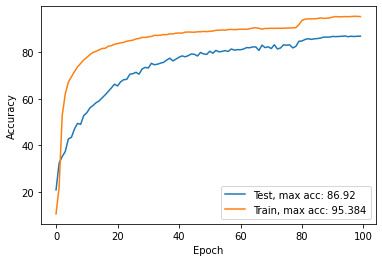

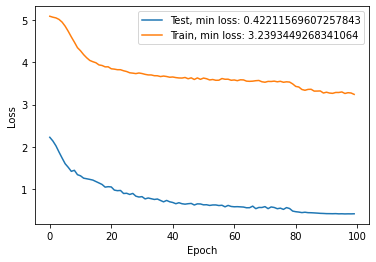

In [ ]:
##Accuracy
acc_train = np.load(res_path + '/' + 'accuracy_per_epoch_train.npy')
acc_test = np.load(res_path + '/' + 'accuracy_per_epoch_val.npy')

#Loss per epoch
loss_train = np.load(res_path + '/' + 'LOSS_epoch_train.npy')
loss_test = np.load(res_path + '/' + 'LOSS_epoch_val.npy')

numEpochs = len(acc_train)
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, acc_test, label='Test, max acc: ' + str(np.max(acc_test)))
plt.plot(epochs, acc_train, label='Train, max acc: ' + str(np.max(acc_train)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(epochs, loss_test, label='Test, min loss: ' + str(np.min(loss_test)))
plt.plot(epochs, loss_train, label='Train, min loss: ' + str(np.min(loss_train)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()